In [43]:
import pandas
import matplotlib.pyplot as pyplot
import numpy

# Read in the data and display the first 5 columns
dataframe = pandas.read_csv('./calendar.csv')

# Set the date column to be a pandas datetime column
dataframe['date'] = pandas.to_datetime(dataframe['date'])

# Set the price column to be a float
dataframe['price'] = dataframe['price'].str.replace('[\$,]', '', regex=True).astype(float)

dataframe.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


To check the price delta between various times of year and between available and unavailable listings...clear up any NaN values for price

In [2]:
# Check if there are any null values in the available or date columns
nullPrices = dataframe['price'].isnull().sum()

notNullPrices = dataframe['price'].value_counts().sum()

nullPrices, notNullPrices

(459028, 934542)

There are 459,028 rows without a price, and 934,542 rows with a price. Check to see if all the rows without a price are rows that are not available

In [3]:
nullPrices = dataframe.loc[dataframe['available'] == 'f']['price'].isnull().sum()

nullPrices

459028

The rows with unavailable listings do not list a price. What are some options for imputing the missing values? Get a list of available listings and prices

In [8]:
availableListings = dataframe.loc[dataframe['available'] == 't'].copy()

availableListings = availableListings[['listing_id', 'price']].groupby(['listing_id', 'price'], as_index=False)

availableListings = availableListings.mean().groupby('listing_id')['price'].mean().round(2)

availableListings = pandas.DataFrame(availableListings.reset_index())

availableListings

,listing_id,price
0,3335,120.00
1,4291,82.00
2,5682,52.50
3,6606,95.00
4,7369,85.00
...,...,...
3718,10331249,45.00
3719,10332096,40.00
3720,10334184,120.00
3721,10339145,262.33


An option would be to take these means values for available listings and fill all nan fields with their respective mean price based on the listing

In [9]:
def findAvailableListingMean(row):
    if numpy.isnan(row['price']):
        try:
            mean_price = availableListings.loc[availableListings['listing_id'] == row['listing_id']]['price'].item()

            return mean_price
        except:
            return row['price']
    else:
        return row['price']

dataframe['price'] = dataframe.apply(
    lambda row: findAvailableListingMean(row),
    axis=1
)

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,85.0
3,241032,2016-01-07,f,85.0
4,241032,2016-01-08,f,85.0
...,...,...,...,...
995,3308979,2016-09-25,t,1450.0
996,3308979,2016-09-26,t,1450.0
997,3308979,2016-09-27,t,1450.0
998,3308979,2016-09-28,t,1450.0


Putting it all together, graph a bar chart with one set being the pricing per month for available listings, and the other unavailable listings

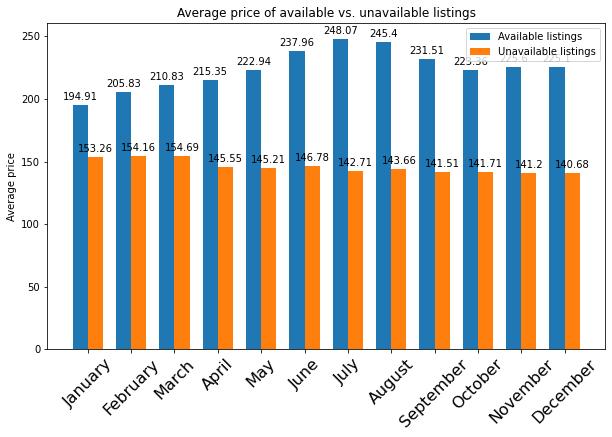

In [42]:
# Slice dataframe into available and unavailable listings
def slice_data_frame_by_availability(availability, _dataframe):
    # Only concerned with 2016 data
    _dataframe = _dataframe.loc[_dataframe['date'].dt.year == 2016].copy()

    # Filter on the availability of the listing
    _dataframe = _dataframe.loc[_dataframe['available'] == availability].copy()

    return _dataframe

availableListings = slice_data_frame_by_availability('t', dataframe)
unavailableListings = slice_data_frame_by_availability('f', dataframe)

# # Group by date, and price
availablePriceByDate = availableListings.groupby(['date', 'price'], as_index=False).size()
unavailablePriceByDate = unavailableListings.groupby(['date', 'price'], as_index=False).size()

# Add the columns that will be grouped and computed to get the mean price per month
availablePriceByDate['month'] = availablePriceByDate['date'].dt.month
unavailablePriceByDate['month'] = unavailablePriceByDate['date'].dt.month

# Set up the plotData
availableListingsPlotData = pandas.DataFrame({'month': availablePriceByDate['month'], 'price': availablePriceByDate['price']}).groupby('month', as_index=False).mean().round(2)
unavailableListingsPlotData = pandas.DataFrame({'month': unavailablePriceByDate['month'], 'price': unavailablePriceByDate['price']}).groupby('month', as_index=False).mean().round(2)

# Set the month column to the month name for the Bar chart
availableListingsPlotData['month'] = pandas.to_datetime(availableListingsPlotData['month'], format='%m').dt.month_name()
unavailableListingsPlotData['month'] = pandas.to_datetime(unavailableListingsPlotData['month'], format='%m').dt.month_name()

# Plot a bar graph detailing average price per month
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

labelLocations = numpy.arange(len(labels))
barWidth = 0.35

figure, graph = pyplot.subplots(figsize=(10, 6))
availableBars = graph.bar(labelLocations - barWidth / 2, availableListingsPlotData['price'], barWidth, label='Available listings')
unavailableBars = graph.bar(labelLocations + barWidth / 2, unavailableListingsPlotData['price'], barWidth, label='Unavailable listings')

# Style the bar graph and add labels
graph.set_ylabel('Average price')
graph.set_title('Average price of available vs. unavailable listings')
graph.set_xticks(labelLocations, labels)
graph.legend()
graph.bar_label(availableBars, padding=3)
graph.bar_label(unavailableBars, padding=3)

pyplot.setp(graph.get_xticklabels(), fontsize=16, rotation='45')
pyplot.show()

By imputing the average price for an available listing onto the NaN values for unavailable listings it's clear there's at least some correlation between price and availability. However, the imputation is limited by a number of factors. For example, a price might be higher due to higher demand which would be missing from the mean.